# Task 2: Sentiment and Thematic Analysis
___
### 1. Setup & Data Loading

In [1]:
import sys
import os

# Add project root (one directory above "notebooks")
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
from transformers import pipeline
from scripts.sentiment_analysis import apply_sentiment_pipeline
from scripts.visualizations import plot_bank_cx_insights,plot_top_keywords_per_bank,plot_wordclouds,plot_theme_distribution
from scripts.theme_extraction import preprocess_text, extract_keywords, assign_themes, apply_full_thematic_analysis

c:\Users\natty\Downloads\KAIM\fintech-app-cx-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../data/processed/cleaned_reviews.csv", parse_dates=["date"])
df.shape  # expect 1547 x 5

(1547, 5)

### 2 Sentiment Analysis with DistilBERT

In [4]:
# Load DistilBERT Sentiment Model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1,           # CPU (set 0 for GPU)
    batch_size=32
)

Device set to use cpu


In [5]:
# Apply Sentiment Model to Reviews
results = apply_sentiment_pipeline(df["review"].tolist(), sentiment_pipeline)

# Clean labels
df["sentiment"] = [r["label"].lower() for r in results]
df["confidence"] = [r["score"] for r in results]

# Map to numeric score
df["sentiment_score"] = df["sentiment"].map({
    "positive": 1,
    "negative": -1
})

print("DistilBERT sentiment analysis complete!")

DistilBERT sentiment analysis complete!


In [6]:
# Quick Check
df["sentiment"].value_counts()

sentiment
positive    970
negative    577
Name: count, dtype: int64

In [7]:
# Mean sentiment score per bank
bank_sentiment = df.groupby("bank")["sentiment_score"].mean().round(3)
print("Average Sentiment Score per Bank (+1 = positive, -1 = negative):")
print(bank_sentiment.sort_values(ascending=False))



# Full breakdown: mean sentiment by bank AND rating
summary = df.groupby(["bank", "rating"])["sentiment_score"].agg(["mean", "count"]).round(3)
summary = summary.rename(columns={"mean": "avg_sentiment_score"})
print("\nDetailed breakdown (required by challenge):")
summary.unstack().style.background_gradient(cmap="RdYlGn", axis=None)

Average Sentiment Score per Bank (+1 = positive, -1 = negative):
bank
DASHEN    0.449
CBE       0.393
BOA      -0.082
Name: sentiment_score, dtype: float64

Detailed breakdown (required by challenge):


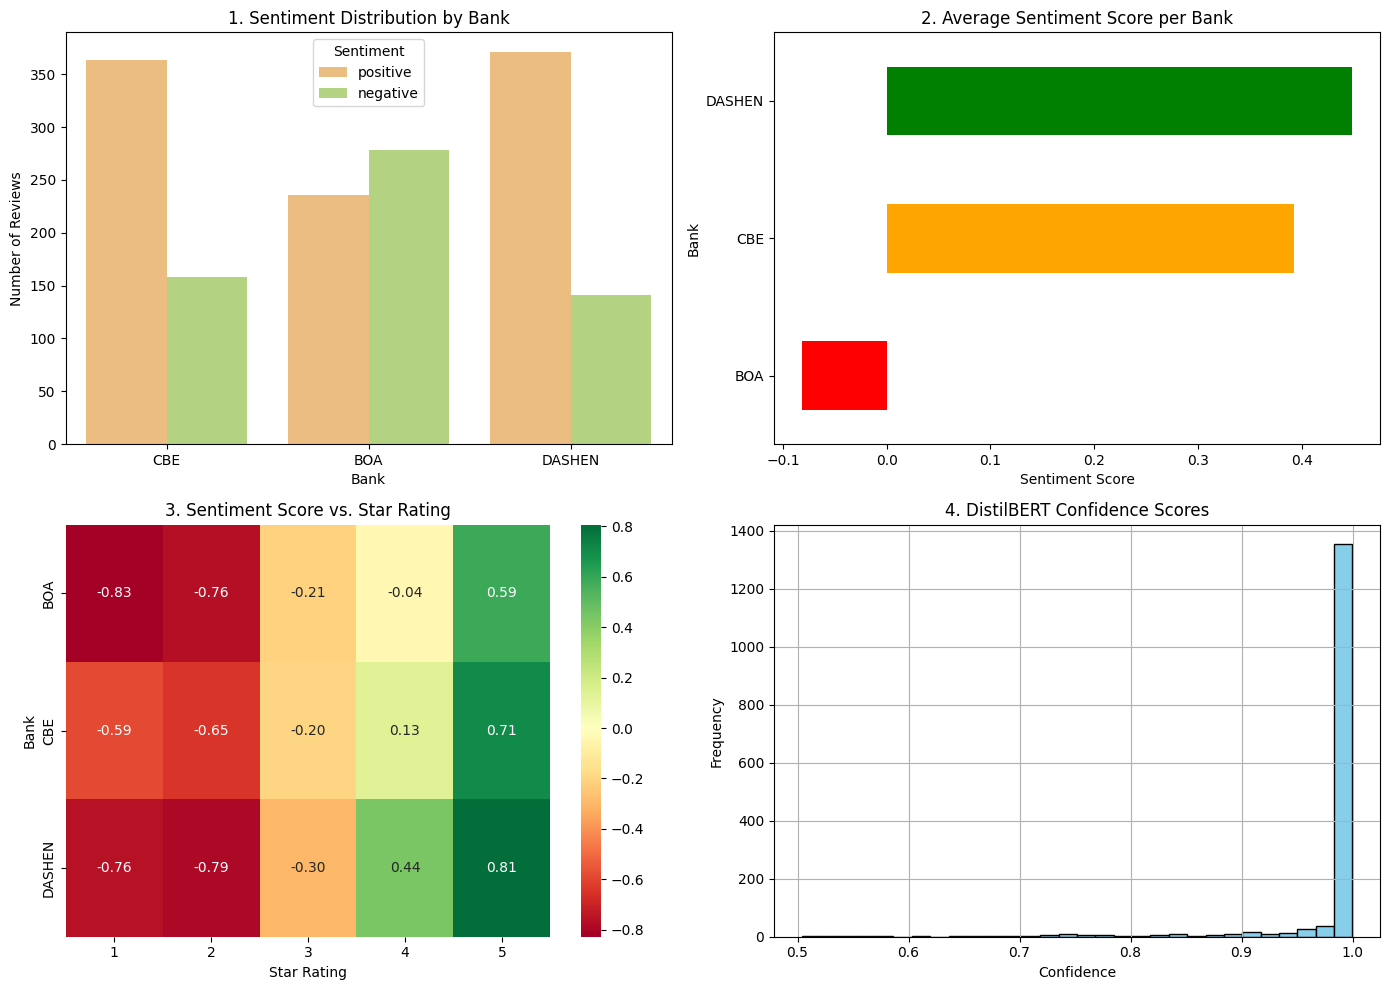

In [8]:
plot_bank_cx_insights(df,bank_sentiment)

In [9]:
# Save Sentiment Output
df.to_csv("../data/processed/reviews_with_sentiment_bert.csv", index=False)
print("💾 Saved processed sentiment dataset.")


💾 Saved processed sentiment dataset.


### 3. Thematic Analysis

In [10]:
# Preprocess + assign themes
df = apply_full_thematic_analysis(df)
df.head(20)

Preprocessing reviews...
Assigning themes...

Theme Distribution:
theme
No Content               618
Other                    518
Transaction Problems     117
Positive Experience       91
Missing Features          62
Slow Performance          34
Account Access Issues     31
App Crashes & Bugs        27
Customer Support          21
User Interface Issues     15
Name: count, dtype: int64


,review,rating,date,bank,source,sentiment,confidence,sentiment_score,processed_review,theme
0,The app makes our life easier. Thank you CBE!,5,2025-11-27,CBE,Google Play Store,positive,0.999696,1,make life easy thank,Positive Experience
1,the most advanced app. but how to stay safe?,5,2025-11-27,CBE,Google Play Store,negative,0.956509,-1,advanced stay safe,Security Concerns
2,Good application,4,2025-11-27,CBE,Google Play Store,positive,0.999855,1,,No Content
3,It is nice app,5,2025-11-26,CBE,Google Play Store,positive,0.999848,1,,No Content
4,best,5,2025-11-25,CBE,Google Play Store,positive,0.999794,1,,No Content
5,good app,5,2025-11-25,CBE,Google Play Store,positive,0.999849,1,,No Content
6,it suddenly asked me to enter the verification...,1,2025-11-25,CBE,Google Play Store,negative,0.999344,-1,ask enter verification key receive verificatio...,Account Access Issues
7,nice app...,5,2025-11-25,CBE,Google Play Store,positive,0.999712,1,,No Content
8,very good banking service and fast service,5,2025-11-24,CBE,Google Play Store,positive,0.999850,1,service fast service,Positive Experience
9,thanks blc this app help me to use all time,5,2025-11-24,CBE,Google Play Store,positive,0.997164,1,thank help use time,Customer Support


In [12]:
# CREATE df_keywords – clean, sorted, ready for everything for analysis
bank_keywords = {
    bank: extract_keywords(
        df[df["bank"] == bank]["processed_review"].tolist(),
        top_k=20
    )
    for bank in df["bank"].unique()
}

bank_keywords


{'CBE': [('update', 0.026135363517763067),
  ('work', 0.02277441063014163),
  ('thank', 0.015332936499953917),
  ('use', 0.015053688180234824),
  ('transaction', 0.01470753962393961),
  ('time', 0.014102055135945257),
  ('like', 0.013769507058849122),
  ('need', 0.011855767749104702),
  ('money', 0.01184812353749765),
  ('account', 0.011778892083730738),
  ('service', 0.01156680680317709),
  ('fast', 0.011520428518190996),
  ('useful', 0.010999273950769061),
  ('transfer', 0.010671692653870787),
  ('option', 0.009059790142381681),
  ('easy', 0.008922295954188995),
  ('feature', 0.008312104807983754),
  ('history', 0.008113337239545847),
  ('friendly', 0.007986203858481854),
  ('user', 0.0076905435063039426)],
 'BOA': [('work', 0.07701843240567915),
  ('use', 0.02403477173389276),
  ('open', 0.023142012468166155),
  ('need', 0.01840126928783767),
  ('update', 0.018082490323787087),
  ('slow', 0.017793380254769106),
  ('service', 0.0172908047096854),
  ('time', 0.01725286320970964),
  ('

In [13]:
# create df_keywords for visualization and analysis
import pandas as pd
rows = []
for bank, keyword_list in bank_keywords.items():
    for rank, (keyword, score) in enumerate(keyword_list, 1):
        rows.append({
            "Bank": bank,
            "Rank": rank,
            "Keyword": keyword,
            "TF-IDF Score": score
        })

# Create the DataFrame
df_keywords = pd.DataFrame(rows)

# Sort properly: first by Bank, then by Score descending
df_keywords = df_keywords.sort_values(["Bank", "TF-IDF Score"], ascending=[True, False]).reset_index(drop=True)
df_keywords.groupby(['Bank','Rank']).first()

Keyword  TF-IDF Score
Bank   Rank                           
BOA    1            work      0.077018
       2             use      0.024035
       3            open      0.023142
       4            need      0.018401
       5          update      0.018082
       6            slow      0.017793
       7         service      0.017291
       8            time      0.017253
       9      experience      0.016168
       10          thank      0.015668
       11          crash      0.015413
       12           fast      0.015207
       13            fix      0.014164
       14            try      0.013557
       15      developer      0.013174
       16          money      0.011896
       17         option      0.010461
       18    transaction      0.010429
       19          phone      0.010110
       20        useless      0.010067
CBE    1          update      0.026135
       2            work      0.022774
       3           thank      0.015333
       4             use      0.015054
       5     transaction      0.014708
       6            time      0.014102
       7            like      0.013770
       8            need      0.011856
       9           money      0.011848
       10        account      0.011779
       11        service      0.011567
       12           fast      0.011520
       13         useful      0.010999
       14       transfer      0.010672
       15         option      0.009060
       16           easy      0.008922
       17        feature      0.008312
       18        history      0.008113
       19       friendly      0.007986
       20           user      0.007691
DASHEN 1            easy      0.031665
       2           super      0.030556
       3             use      0.030176
       4            fast      0.029436
       5            work      0.026909
       6            slow      0.021547
       7         feature      0.018401
       8            user      0.017167
       9            time      0.017003
       10       easy use      0.016720
       11           need      0.015021
       12        service      0.014991
       13           step      0.014840
       14    transaction      0.014783
       15       friendly      0.014702
       16          thank      0.014626
       17     experience      0.014451
       18         supper      0.013103
       19       reliable      0.012777
       20         secure      0.012570

In [14]:
print("THEME DISTRIBUTION ACROSS ALL BANKS")
theme_counts = df["theme"].value_counts()
print(theme_counts)

# Per-bank theme breakdown
print("\nTHEMES BY BANK")
theme_by_bank = df.groupby(["bank", "theme"]).size().unstack(fill_value=0)
theme_by_bank = theme_by_bank[theme_counts.index]  # same order
display(theme_by_bank.style.background_gradient(cmap="YlOrRd", axis=1))

THEME DISTRIBUTION ACROSS ALL BANKS
theme
No Content               618
Other                    518
Transaction Problems     117
Positive Experience       91
Missing Features          62
Slow Performance          34
Account Access Issues     31
App Crashes & Bugs        27
Customer Support          21
User Interface Issues     15
Security Concerns         13
Name: count, dtype: int64

THEMES BY BANK


theme,No Content,Other,Transaction Problems,Positive Experience,Missing Features,Slow Performance,Account Access Issues,App Crashes & Bugs,Customer Support,User Interface Issues,Security Concerns
bank,,,,,,,,,,,
BOA,188,202,31,15,15,18,11,22,5,6,1
CBE,260,150,41,19,21,3,10,1,9,3,4
DASHEN,170,166,45,57,26,13,10,4,7,6,8


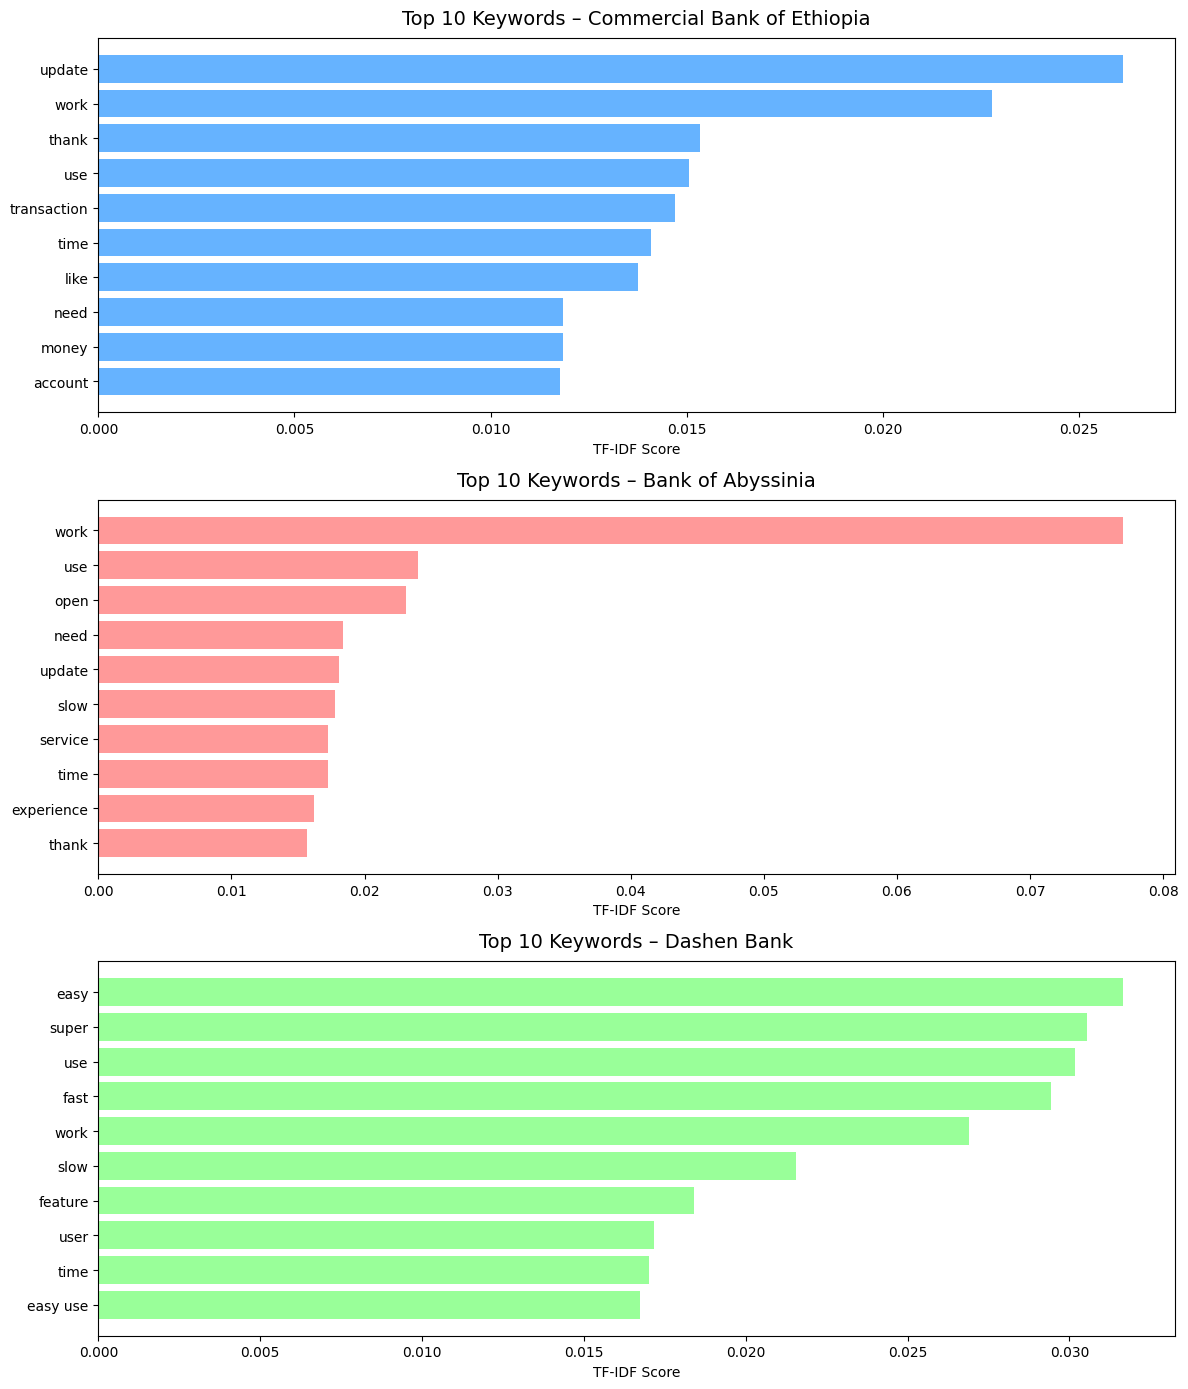

<Figure size 1200x800 with 0 Axes>

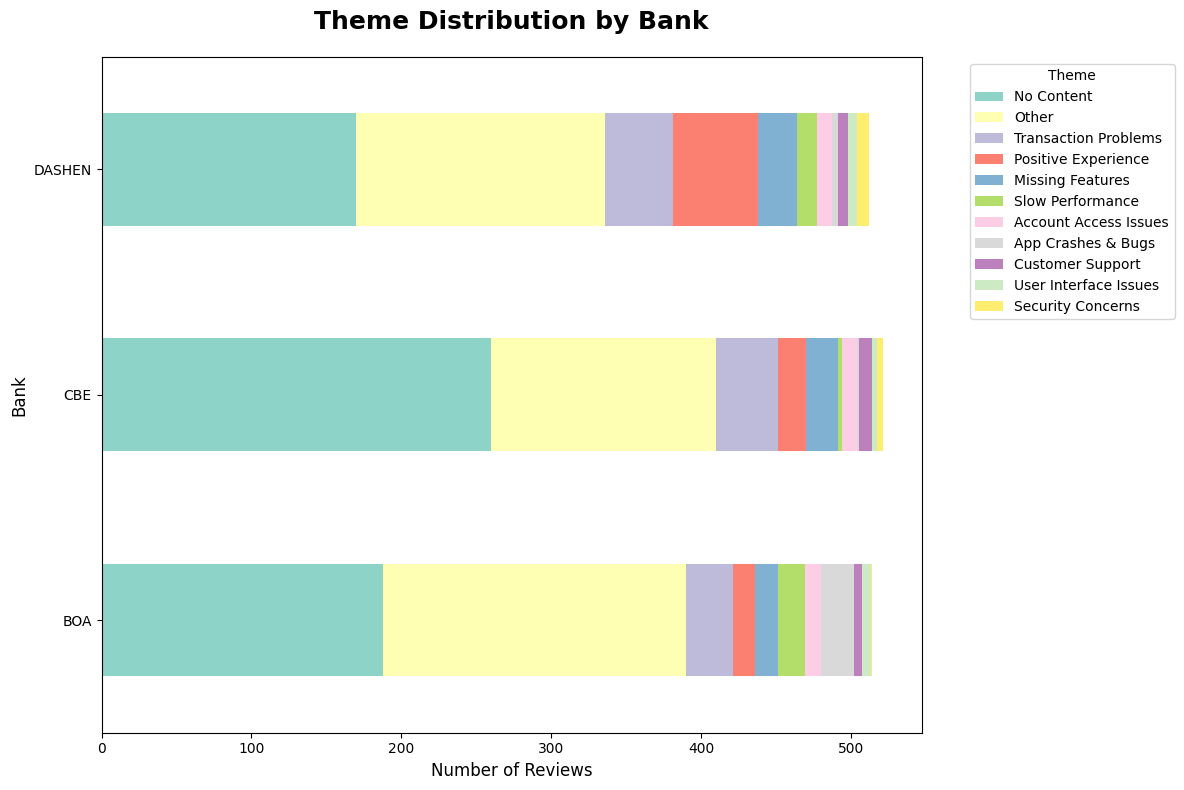

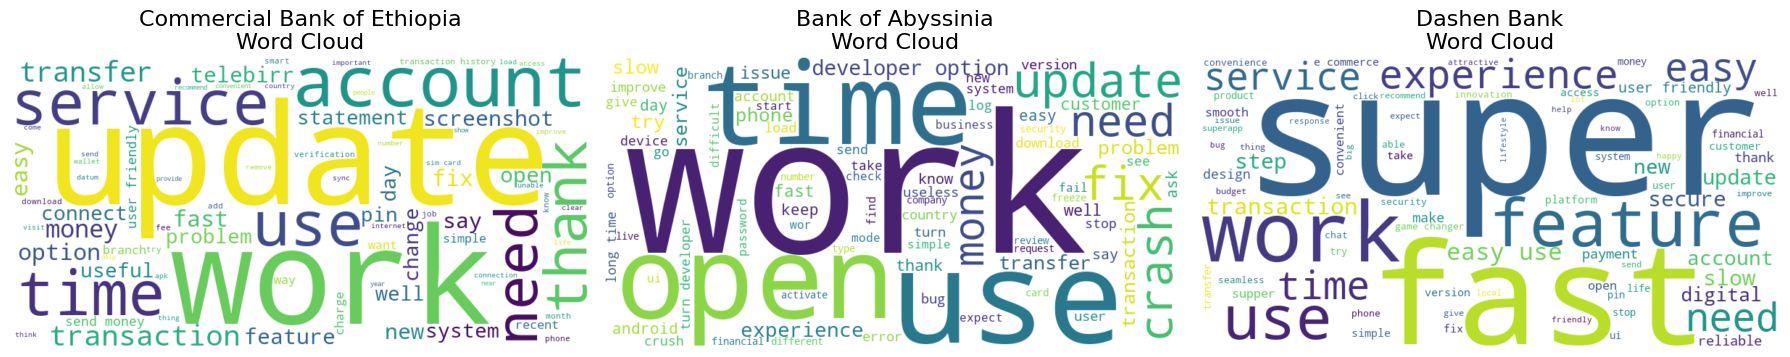

In [15]:
# Assuming you already have these objects ready:
# df, bank_sentiment, df_keywords, theme_by_bank
plot_top_keywords_per_bank(df_keywords, top_n=10)
plot_theme_distribution(theme_by_bank)
plot_wordclouds(df, banks=["CBE", "BOA", "DASHEN"])

In [17]:
# Save Sentiment Output
df.to_csv("../data/processed/cleaned_reviews_with_themes.csv", index=False)
print("💾 Saved processed sentiment dataset.")

💾 Saved processed sentiment dataset.
